## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [8]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [10]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [11]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [12]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


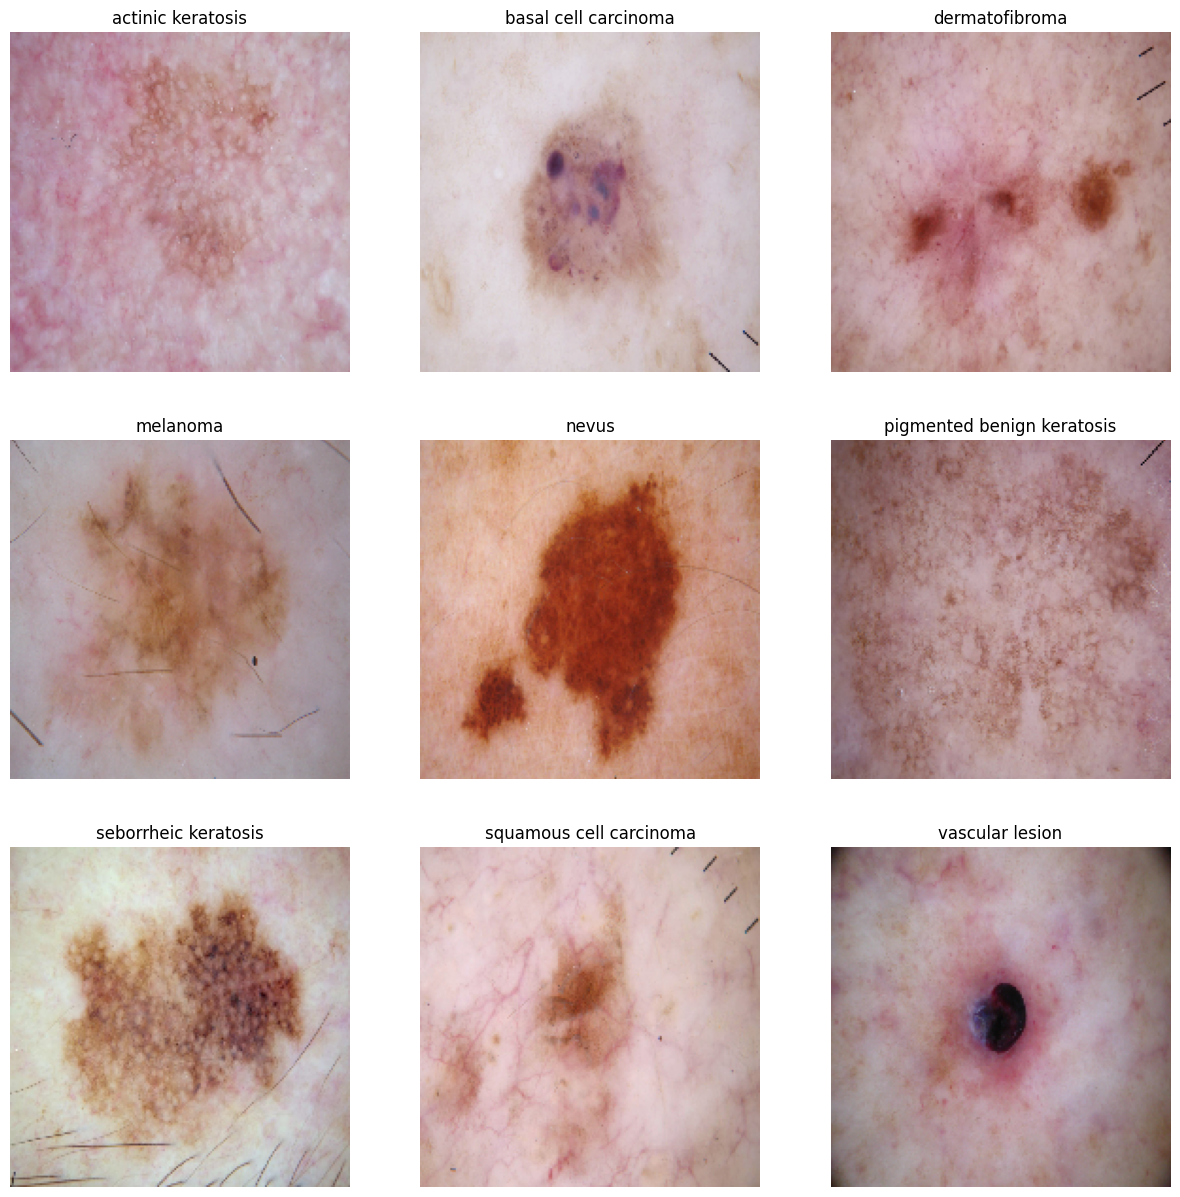

In [13]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [14]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,actinic keratosis,114
2,dermatofibroma,95
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,vascular lesion,139
6,basal cell carcinoma,376
7,squamous cell carcinoma,181
8,melanoma,438


In [20]:
# prompt: Using dataframe df: pandas
# to demonstrate how to work with this dataframe.

# Display the first 5 rows of the dataframe.
print(df.head())

# Get some basic statistics of the dataframe.
print(df.describe())

# Check the data types of each column.
print(df.dtypes)

# Sort the dataframe by the "No. of Image" column in descending order.
print(df.sort_values("No. of Image", ascending=False))


                        Class  No. of Image
0                       nevus           357
1           actinic keratosis           114
2              dermatofibroma            95
3        seborrheic keratosis            77
4  pigmented benign keratosis           462
       No. of Image
count      9.000000
mean     248.777778
std      156.975936
min       77.000000
25%      114.000000
50%      181.000000
75%      376.000000
max      462.000000
Class           object
No. of Image     int64
dtype: object
                        Class  No. of Image
4  pigmented benign keratosis           462
8                    melanoma           438
6        basal cell carcinoma           376
0                       nevus           357
7     squamous cell carcinoma           181
5             vascular lesion           139
1           actinic keratosis           114
2              dermatofibroma            95
3        seborrheic keratosis            77


<Axes: xlabel='No. of Image', ylabel='Class'>

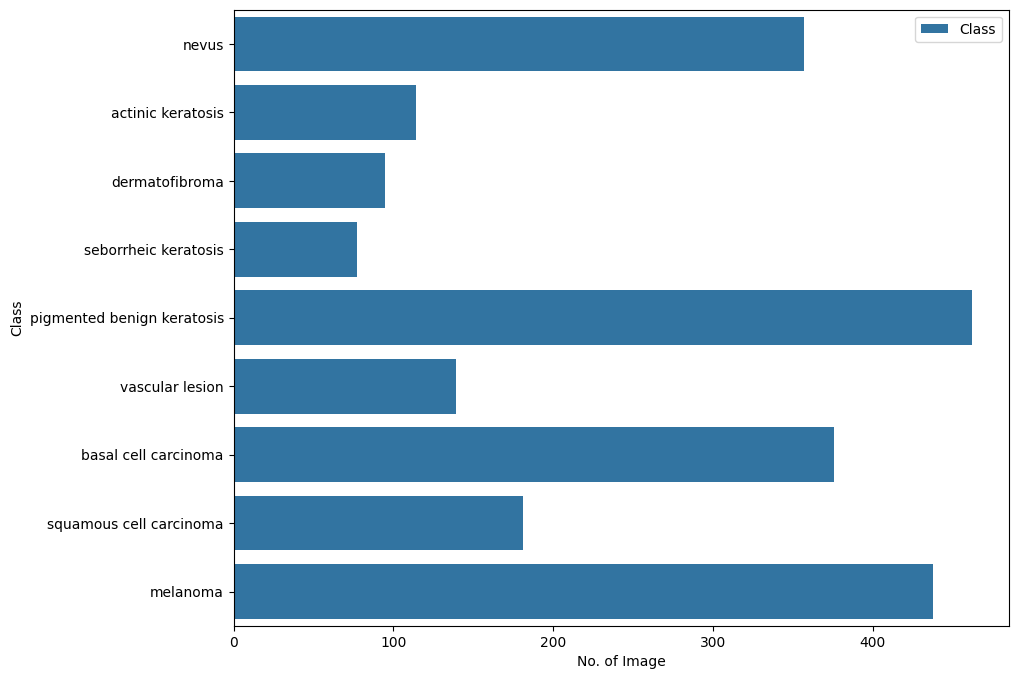

In [17]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [18]:
#install Augmentor
!pip install Augmentor

In [19]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2F00164D50>: 100%|██████████| 500/500 [00:14<00:00, 34.37 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A2EEFFDCBD0>: 100%|██████████| 500/500 [00:14<00:00, 35.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2EEFF72B90>: 100%|██████████| 500/500 [00:14<00:00, 34.87 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A2F00164D50>: 100%|██████████| 500/500 [01:11<00:00,  7.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A2F255F4650>: 100%|██████████| 500/500 [01:18<00:00,  6.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2F0045C810>: 100%|██████████| 500/500 [00:14<00:00, 34.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A2F22EE5550>: 100%|██████████| 500/500 [00:34<00:00, 14.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A2F04DD2F10>: 100%|██████████| 500/500 [00:14<00:00, 35.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A2F21173390>: 100%|██████████| 500/500 [00:14<00:00, 34.23 Samples/s]


In [21]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**

In [22]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [23]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [24]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer (Modified)
# The Rescaling layer is no longer under 'experimental.preprocessing'
model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

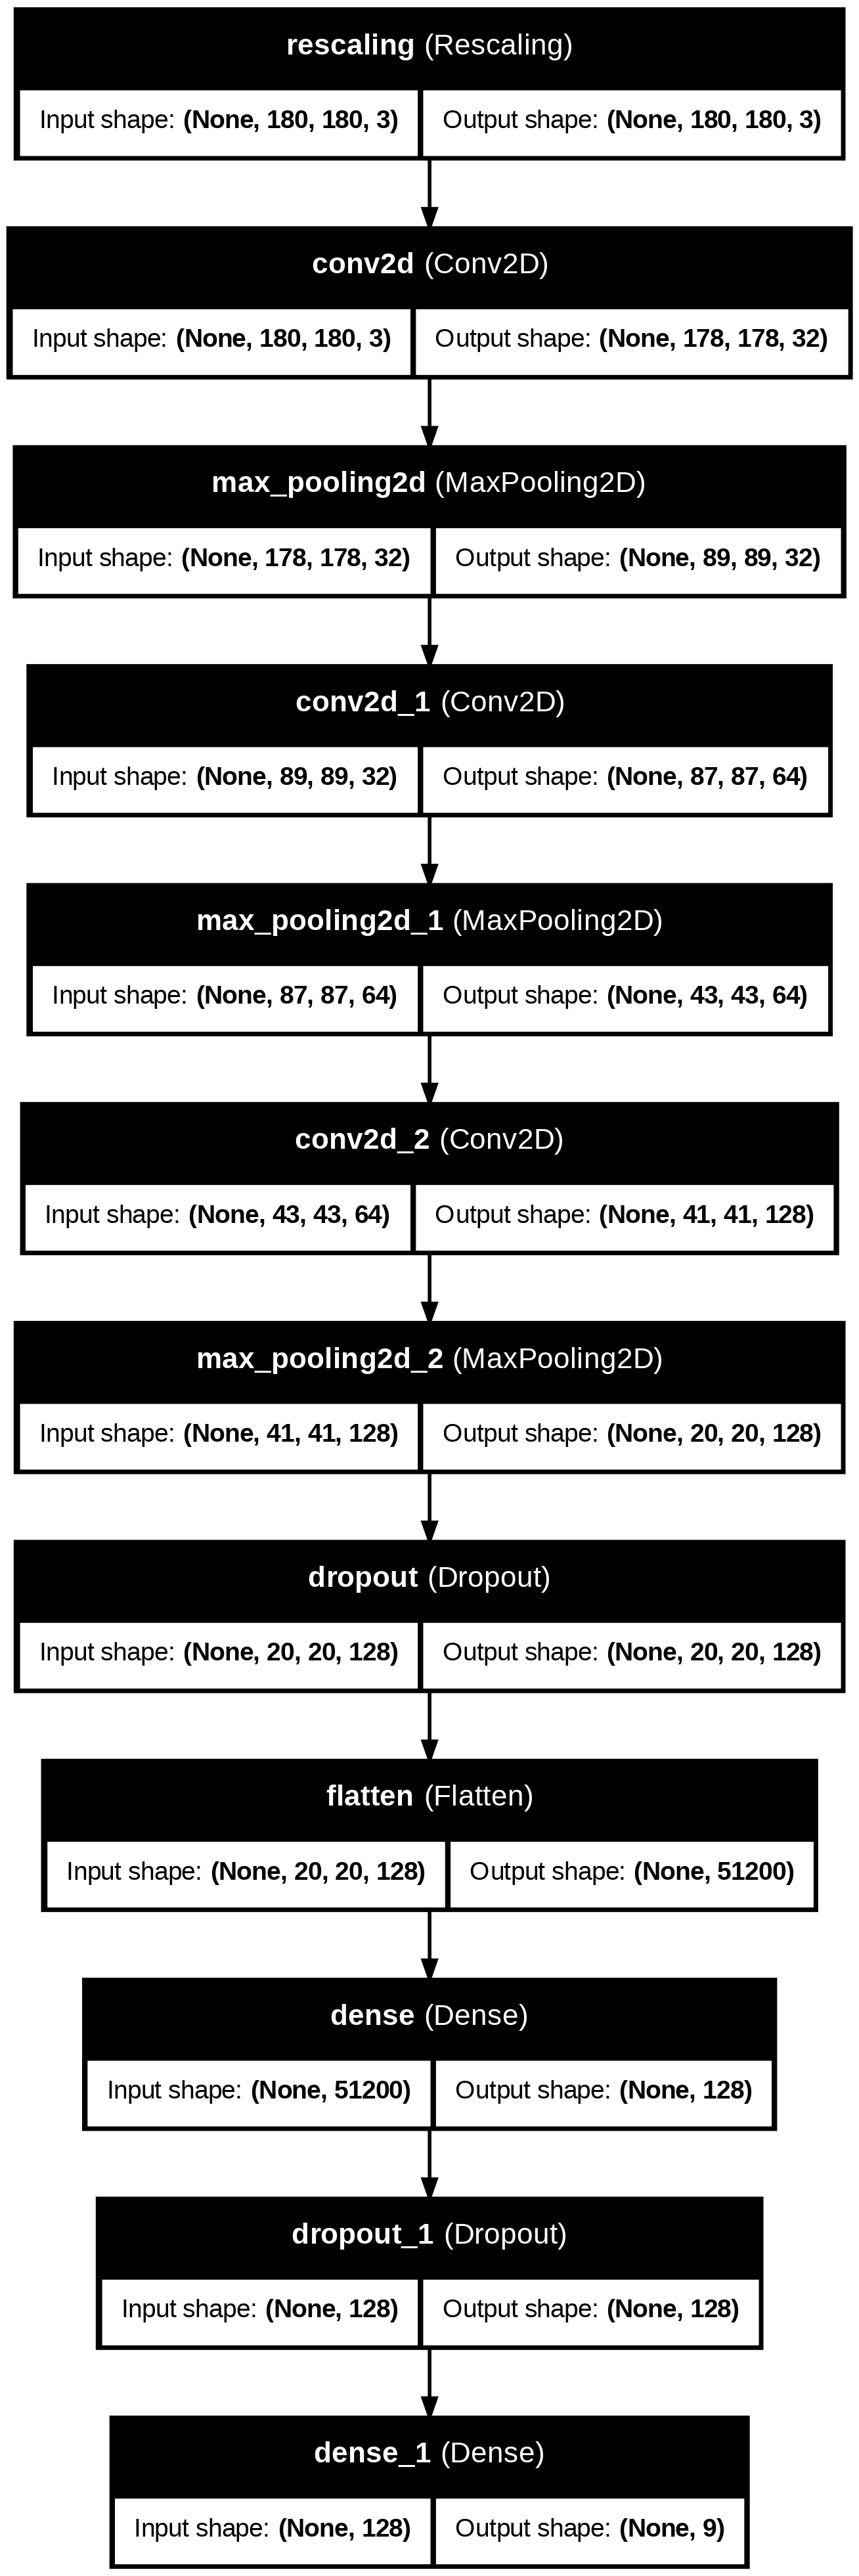

In [29]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [31]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2013 - loss: 2.1991
Epoch 1: val_accuracy improved from -inf to 0.41203, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.2021 - loss: 2.1960 - val_accuracy: 0.4120 - val_loss: 1.5398
Epoch 2/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4019 - loss: 1.5618
Epoch 2: val_accuracy improved from 0.41203 to 0.42539, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4021 - loss: 1.5614 - val_accuracy: 0.4254 - val_loss: 1.4923
Epoch 3/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4576 - loss: 1.4217
Epoch 3: val_accuracy improved from 0.42539 to 0.48924, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4578 - loss: 1.4213 - val_accuracy: 0.4892 - val_loss: 1.3372
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5076 - loss: 1.2778
Epoch 4: val_accuracy improved from 0.48924 to 0.53452, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5076 - loss: 1.2778 - val_accuracy: 0.5345 - val_loss: 1.2047
Epoch 5/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5622 - loss: 1.1611
Epoch 5: val_accuracy improved from 0.53452 to 0.56793, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5622 - loss: 1.1613 - val_accuracy: 0.5679 - val_loss: 1.0965
Epoch 6/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5998 - loss: 1.0846
Epoch 6: val_accuracy improved from 0.56793 to 0.59094, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5999 - loss: 1.0844 - val_accuracy: 0.5909 - val_loss: 1.0384
Epoch 7/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6389 - loss: 0.9814
Epoch 7: val_accuracy improved from 0.59094 to 0.65479, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6389 - loss: 0.9816 - val_accuracy: 0.6548 - val_loss: 0.9333
Epoch 8/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6669 - loss: 0.8797
Epoch 8: val_accuracy did not improve from 0.65479
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6668 - loss: 0.8801 - val_accuracy: 0.6088 - val_loss: 1.0559
Epoch 9/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7065 - loss: 0.8070
Epoch 9: val_accuracy improved from 0.65479 to 0.70973, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7065 - loss: 0.8069 - val_accuracy: 0.7097 - val_loss: 0.8015
Epoch 10/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7393 - loss: 0.7211
Epoch 10: val_accuracy improved from 0.70973 to 0.74313, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7392 - loss: 0.7215 - val_accuracy: 0.7431 - val_loss: 0.7267
Epoch 11/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7551 - loss: 0.6576
Epoch 11: val_accuracy improved from 0.74313 to 0.75947, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7552 - loss: 0.6575 - val_accuracy: 0.7595 - val_loss: 0.7017
Epoch 12/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7864 - loss: 0.5625
Epoch 12: val_accuracy improved from 0.75947 to 0.80178, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7864 - loss: 0.5625 - val_accuracy: 0.8018 - val_loss: 0.5834
Epoch 13/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8136 - loss: 0.5119
Epoch 13: val_accuracy did not improve from 0.80178
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8134 - loss: 0.5124 - val_accuracy: 0.7691 - val_loss: 0.6569
Epoch 14/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8049 - loss: 0.5097
Epoch 14: val_accuracy did not improve from 0.80178
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8050 - loss: 0.5097 - val_accuracy: 0.7624 - val_loss: 0.6713
Epoch 15/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8261 - loss: 0.4547
Epoch 15: val_accuracy improved from 0.80178 to 0.81292, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8262 - loss: 0.4546 - val_accuracy: 0.8129 - val_loss: 0.5888
Epoch 16/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8413 - loss: 0.4215
Epoch 16: val_accuracy did not improve from 0.81292
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8412 - loss: 0.4219 - val_accuracy: 0.8099 - val_loss: 0.5668
Epoch 17/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8417 - loss: 0.4100
Epoch 17: val_accuracy did not improve from 0.81292
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8416 - loss: 0.4104 - val_accuracy: 0.7862 - val_loss: 0.6479
Epoch 18/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8343 - loss: 0.4290
Epoch 18: val_accuracy improved from 0.81292 to 0.84707, saving model to model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8345 - loss: 0.4286 - val_accuracy: 0.8471 - val_loss: 0.5482
Epoch 19/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8614 - loss: 0.3509
Epoch 19: val_accuracy did not improve from 0.84707
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8615 - loss: 0.3507 - val_accuracy: 0.8315 - val_loss: 0.5743
Epoch 20/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8662 - loss: 0.3200
Epoch 20: val_accuracy did not improve from 0.84707
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8662 - loss: 0.3200 - val_accuracy: 0.8389 - val_loss: 0.5262


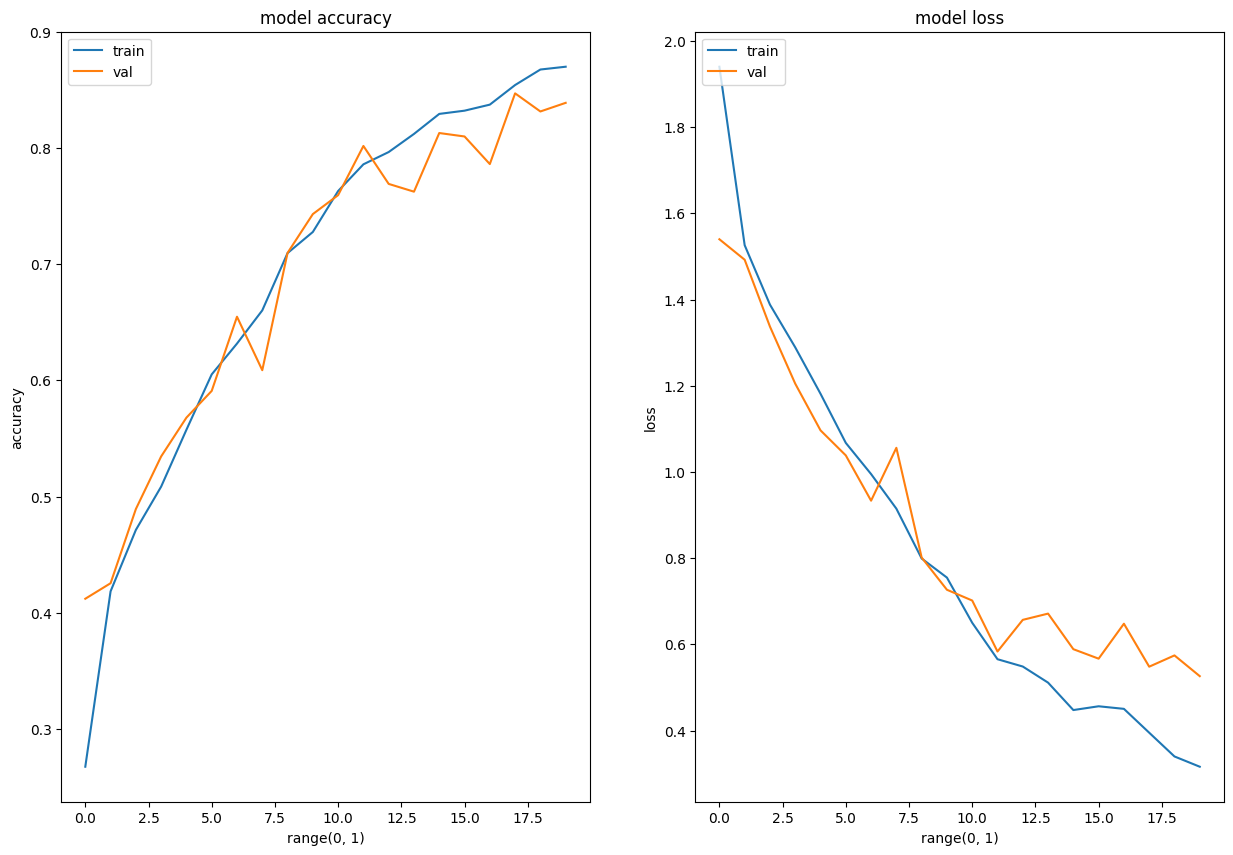

In [32]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


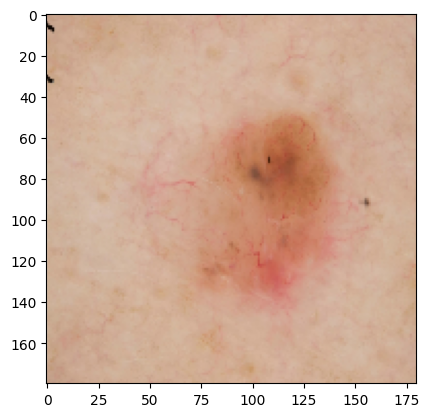

In [45]:
from keras.preprocessing.image import img_to_array
from glob import glob
Test_image = img_to_array(Test_image)
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )